# Titanic - Machine Learning from Disaster: постороение предиктивной модели с использованием нейронных сетей

Продолжаем работу с датасетом Kaggle о крушении "Титаника". После построения ансамбля моделей классификации с помощью VotingClassifier в предыдущем блокноте, мы переходим к использованию нейросетей для определения у кого из пассажиров были шансы выжить.

## Импорт и установка библиотек

In [1]:
!pip install feature_engine;

In [2]:
# модули для работы с данными и визуализации

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## The Scikit-Learn Library for train test split and accuracy evaluation
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from feature_engine.encoding import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report


## Tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


#import warnings
#warnings.filterwarnings('ignore')

### Загрузка датасета

In [3]:
train_data = pd.read_csv('train.csv')

In [4]:
test_data = pd.read_csv('test.csv')

Обзор данных мы делали в предыдущем [блокноте](https://github.com/EwanRyzhov/Kaggle/blob/main/Titanic/Titanic_GB.ipynb). Но в этот раз предобработку будет несколько изменена.

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Предобработка данных

Обзор данных (описание признаков, доля пропусков, агрегированные показатели) вынесен в первый блокнот по Титанику, где обучалась модель с применением градиентного бустинга.

### Визуализация данных

In [6]:
sns.set_palette("RdYlBu")

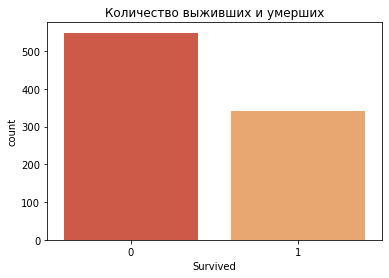

In [7]:
sns.countplot(x=train_data['Survived']).set_title('Количество выживших и умерших')
plt.show()

Количество выживших несколько меньше, чем умерших — но дисбаланс классов не такой сильный, как можно было бы ожидать.

C:\Users\rizho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\rizho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


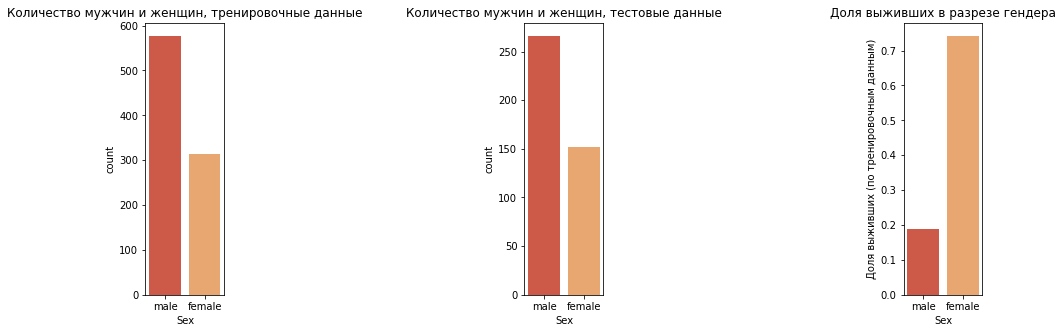

In [8]:
fig = plt.figure(figsize=([15,5]))

ax_1 = fig.add_subplot(1,9,1)
ax_2 = fig.add_subplot(1,9,5)
ax_3 = fig.add_subplot(1,9,9)

sns.countplot(train_data['Sex'], ax=ax_1)
sns.countplot(test_data['Sex'], ax=ax_2)
sns.barplot(x='Sex', y='Survived', data=train_data, ax=ax_3, ci=None)

ax_1.set_title('Количество мужчин и женщин, тренировочные данные')
ax_2.set_title('Количество мужчин и женщин, тестовые данные')
ax_3.set_title('Доля выживших в разрезе гендера')
ax_3.set_ylabel('Доля выживших (по тренировочным данным)')
plt.show()

"Ladies first!" — доля вышивших женщин более чем в три раза больше доли вышивших женщин. Что важно, распределение мужчин и женщин в тренировочном и тестовом наборах совпадают. 

### Работа с пропусками

#### Пропуски по возрасту

Определим функцию-фильтр, которая определит, как обращались к пассажиру. Функция будет основана на специфической записи в признаке `Name`.

In [9]:
def filter_name(name):
    text = name[name.find(', ') + 2 : name.find('.')]
    return text
    
train_data['Name'] = train_data['Name'].apply(filter_name)
test_data['Name'] = test_data['Name'].apply(filter_name)

In [10]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Mrs,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Mrs,female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,Mr,male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,Mr,male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,Mrs,female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,Mr,male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,Mr,male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,Mrs,female,22.0,1,1,3101298,12.2875,NaN,S


Посмотрим на пассажиров с пропущенным возрастом — как к ним обращались:

In [12]:
pd.unique(train_data[train_data['Age'].isna()]['Name'])

array(['Mr', 'Mrs', 'Miss', 'Master', 'Dr'], dtype=object)

In [13]:
pd.unique(test_data[test_data['Age'].isna()]['Name'])

array(['Mr', 'Mrs', 'Miss', 'Ms', 'Master'], dtype=object)

Рассчитаем средний возраст для каждого обращения:

In [14]:
mean_age_mr = round((train_data[train_data["Name"]=='Mr']['Age'].mean()+
              test_data[test_data['Name']=='Mr']['Age'].mean())/2)

mean_age_mrs = round((train_data[train_data["Name"]=='Mrs']['Age'].mean()+
               test_data[test_data['Name']=='Mrs']['Age'].mean())/2)

mean_age_miss = round((train_data[train_data["Name"]=='Miss']['Age'].mean()+
                test_data[test_data['Name']=='Miss']['Age'].mean())/2)

mean_age_ms = round((train_data[train_data["Name"]=='Ms']['Age'].mean())) # в тесте только 1 пустая запись для Ms
                    
mean_age_master = round((train_data[train_data["Name"]=='Master']['Age'].mean()+
                         test_data[test_data['Name']=='Master']['Age'].mean())/2)
                    
mean_age_dr = round((train_data[train_data["Name"]=='Dr']['Age'].mean()+
              test_data[test_data['Name']=='Dr']['Age'].mean())/2)


Заполним пропуски в возрасте исходя из того, как обращались к пассажиру. Для этого определим новую функцию.

In [15]:
def fill_missing_age(name_age):
    
    name = name_age[0]
    age = name_age[1]
    
    if pd.isnull(age):
        if 'Mr' == name:
            return mean_age_mr
        if 'Mrs' == name:
            return mean_age_mrs
        if 'Miss' == name:
            return mean_age_miss
        if 'Master' == name:
            return mean_age_master
        if 'Dr' == name:
            return mean_age_dr
        if 'Ms' == name:
            return mean_age_miss
    else:
        return age
    
    
# Need updation
train_data['Age'] = train_data[['Name', 'Age']].apply(fill_missing_age,axis=1)
test_data['Age'] = test_data[['Name', 'Age']].apply(fill_missing_age,axis=1)

print('Age is updated')

Age is updated


#### Пропуски в Fare

В признаке `Fare` имеется единственное пропущенное значение — потеря одного объекта вряд ли существенно повлияет на точность модели, но тем не менее мы заполним пропуск медианным значением.

In [16]:
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())

#### Пропуски по пункту посадки

Прежде чем заполнить пропуски в `Embarked`, проверим влияет ли порт посадки на шанс выжить в кораблекрушении

Text(0.5, 1.0, 'Доля выживших, среди севших в разных портах, тренировочные данные')

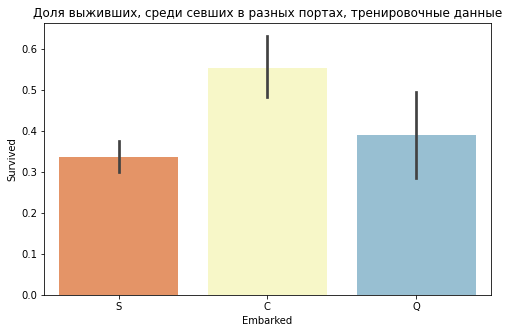

In [17]:
fig = plt.figure(figsize = (8,5))

chart = sns.barplot(x="Embarked",y="Survived",data = train_data, palette = "RdYlBu")
chart.set_title('Доля выживших, среди севших в разных портах, тренировочные данные')

У поднявшихся на борт в Cherbourg доля выживших сильно выше - более 50%, а вот среди пассажиров из Southampton'a их чуть больше 30%. 

In [18]:
train_data[train_data['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,Miss,female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,Mrs,female,62.0,0,0,113572,80.0,B28,NaN


In [19]:
test_data[test_data['Embarked'].isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


У двух женщин с неизвестным портом посадки на борту отсутствовали родственники и восстановить пропуски проблематично. Отбросим эти два объекта (они относятся к тренировочной выборке).

In [20]:
train_data = train_data[~train_data['Embarked'].isna()]

### Удаление неинформативных признаков признаков

In [21]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Mrs,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Mrs,female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,Mr,male,35.0,0,0,373450,8.0500,NaN,S


Часть информации о пассажире явлется избыточной и не несет пользы для модели:
- номер билета `Ticket` — просто набор символов;
- после заполнения пропусков по возрасту, нет необходимости в поле 'Name';
- `Cabin` — большое количество пропусков.

In [22]:
train_data = train_data.drop(columns=['Name','Ticket','Cabin'])
test_data = test_data.drop(columns=['Name','Ticket','Cabin'])

### Категоризация по членам семьи

Сейчас два признака хранят информацию о членах семьи на борту — заменим их на один агрегированный признак.

Для тренировочных данных:

In [23]:
train_data['Family'] = train_data['SibSp'] + train_data['Parch']          # складываем значения в столбцах
train_data.drop(columns=['SibSp', 'Parch'], inplace=True)                 # отбрасываем излишние признаки

train_data['Family'].value_counts()                                       # смотрим на распределение по признаку

0     535
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family, dtype: int64

Для тестовых данных:

In [24]:
test_data['Family'] = test_data['SibSp'] + test_data['Parch']          # складываем значения в столбцах
test_data.drop(columns=['SibSp', 'Parch'], inplace=True)               # отбрасываем излишние признаки

test_data['Family'].value_counts()                                     # смотрим на распределение по признаку

0     253
1      74
2      57
3      14
4       7
6       4
10      4
5       3
7       2
Name: Family, dtype: int64

Большинство путешествовали в одиночку, а пассажиров с большим количеством родственников на борту вообще почти не было — уменьшим количество групп, установив для всех у кого более 5 родственников на борту значение 5.

In [25]:
train_data.loc[train_data.Family>4, 'Family'] = 5
train_data.Family.value_counts()

0    535
1    161
2    102
5     47
3     29
4     15
Name: Family, dtype: int64

In [26]:
test_data.loc[test_data.Family>4, 'Family'] = 5
test_data.Family.value_counts()

0    253
1     74
2     57
3     14
5     13
4      7
Name: Family, dtype: int64

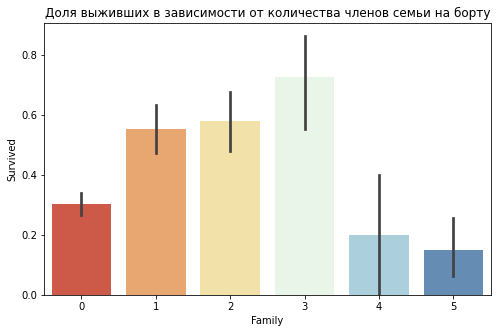

In [27]:
fig = plt.figure(figsize = (8,5))
chart = sns.barplot(x="Family",y="Survived",data = train_data, palette = "RdYlBu")
chart.set_title('Доля выживших в зависимости от количества членов семьи на борту')
plt.show()

Cемья небольшого размера увеливала шансы выжить (помощь и взаимовыручка), а вот большая — существенно их снижала.

### Данные после преобразований

In [28]:
train_data.head(10)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,1,0,3,male,22.0,7.2500,S,1
1,2,1,1,female,38.0,71.2833,C,1
2,3,1,3,female,26.0,7.9250,S,0
3,4,1,1,female,35.0,53.1000,S,1
4,5,0,3,male,35.0,8.0500,S,0
5,6,0,3,male,32.0,8.4583,Q,0
6,7,0,1,male,54.0,51.8625,S,0
7,8,0,3,male,2.0,21.0750,S,4
8,9,1,3,female,27.0,11.1333,S,2
9,10,1,2,female,14.0,30.0708,C,1


In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Sex          889 non-null    object 
 4   Age          889 non-null    float64
 5   Fare         889 non-null    float64
 6   Embarked     889 non-null    object 
 7   Family       889 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 94.8+ KB


Для тренировки модели у нас осталось 889 объектов.

In [30]:
test_data.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Family
0,892,3,male,34.5,7.8292,Q,0
1,893,3,female,47.0,7.0000,S,1
2,894,2,male,62.0,9.6875,Q,0
3,895,3,male,27.0,8.6625,S,0
4,896,3,female,22.0,12.2875,S,2
5,897,3,male,14.0,9.2250,S,0
6,898,3,female,30.0,7.6292,Q,0
7,899,2,male,26.0,29.0000,S,2
8,900,3,female,18.0,7.2292,C,0
9,901,3,male,21.0,24.1500,S,2


In [31]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age          418 non-null    float64
 4   Fare         418 non-null    float64
 5   Embarked     418 non-null    object 
 6   Family       418 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


## Обучение модели

### Зависимость признаков

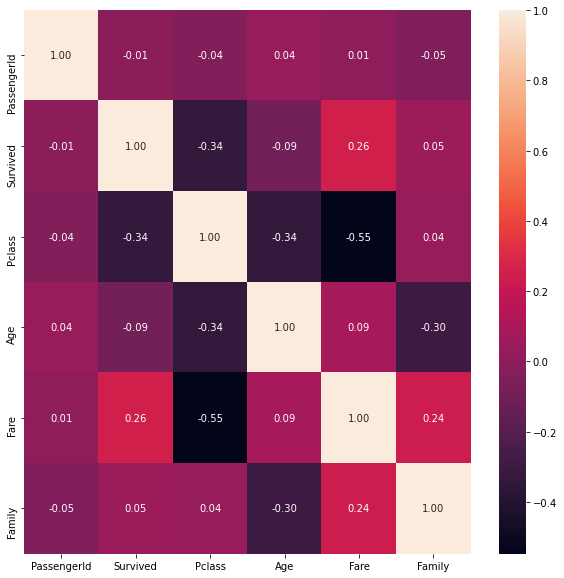

In [32]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(), annot=True, fmt='.2f')
plt.show()

### Категориальные признаки

In [33]:
ohe = OneHotEncoder(variables=['Sex', 'Embarked'])
train_data = ohe.fit_transform(train_data)
test_data = ohe.fit_transform(test_data)

In [34]:
train_data.head()

,PassengerId,Survived,Pclass,Age,Fare,Family,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q
0,1,0,3,22.0,7.2500,1,1,0,1,0,0
1,2,1,1,38.0,71.2833,1,0,1,0,1,0
2,3,1,3,26.0,7.9250,0,0,1,1,0,0
3,4,1,1,35.0,53.1000,1,0,1,1,0,0
4,5,0,3,35.0,8.0500,0,1,0,1,0,0


### Нормализация признаков

Приведем признаки к новому масштабу, но перед этим отделим целевой признак в обучающей выборке.

In [35]:
features_train = train_data.drop(columns=['Survived', 'PassengerId'])
target_train   = train_data['Survived'].astype(int)

In [36]:
dfps = test_data.PassengerId
test_data.drop(['PassengerId'], inplace=True, axis=1)

In [37]:
test_data

,Pclass,Age,Fare,Family,Sex_male,Sex_female,Embarked_Q,Embarked_S,Embarked_C
0,3,34.5,7.8292,0,1,0,1,0,0
1,3,47.0,7.0000,1,0,1,0,1,0
2,2,62.0,9.6875,0,1,0,1,0,0
3,3,27.0,8.6625,0,1,0,0,1,0
4,3,22.0,12.2875,2,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
413,3,32.0,8.0500,0,1,0,0,1,0
414,1,39.0,108.9000,0,0,1,0,0,1
415,3,38.5,7.2500,0,1,0,0,1,0
416,3,32.0,8.0500,0,1,0,0,1,0


In [38]:
train_data

,PassengerId,Survived,Pclass,Age,Fare,Family,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q
0,1,0,3,22.0,7.2500,1,1,0,1,0,0
1,2,1,1,38.0,71.2833,1,0,1,0,1,0
2,3,1,3,26.0,7.9250,0,0,1,1,0,0
3,4,1,1,35.0,53.1000,1,0,1,1,0,0
4,5,0,3,35.0,8.0500,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,13.0000,0,1,0,1,0,0
887,888,1,1,19.0,30.0000,0,0,1,1,0,0
888,889,0,3,22.0,23.4500,3,0,1,1,0,0
889,890,1,1,26.0,30.0000,0,1,0,0,1,0


In [39]:
ss = StandardScaler()

features_train = ss.fit_transform(features_train)
test_data = ss.transform(test_data)

C:\Users\rizho\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


### Архитектура модели TensorFlow

In [40]:
features_train.shape, test_data.shape 

((889, 9), (418, 9))

In [44]:
model = tf.keras.Sequential([tf.keras.layers.Dense(150, activation='relu', input_shape = (9,)),
                             tf.keras.layers.Dropout(0.6),
                             tf.keras.layers.Dense(100, activation='relu'),
                             tf.keras.layers.Dropout(0.15),
                             tf.keras.layers.Dense(50, activation='relu'),
                             tf.keras.layers.Dropout(0.15),
                             tf.keras.layers.Dense(20, activation='relu'),
                             tf.keras.layers.Dropout(0.6),
                             tf.keras.layers.Dense(1,activation='sigmoid')])

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 150)               1500      
                                                                 
 dropout_4 (Dropout)         (None, 150)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               15100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 50)                5050      
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 20)               

In [46]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='accuracy',patience=10)

history=model.fit(features_train, target_train, callbacks=[es], epochs=150)

Epoch 1/150
28/28 [==============================] - 1s 3ms/step - loss: 0.6398 - accuracy: 0.6378
Epoch 2/150
28/28 [==============================] - 0s 2ms/step - loss: 0.5594 - accuracy: 0.7548
Epoch 3/150
28/28 [==============================] - 0s 2ms/step - loss: 0.5578 - accuracy: 0.7312
Epoch 4/150
28/28 [==============================] - 0s 2ms/step - loss: 0.5211 - accuracy: 0.7694
Epoch 5/150
28/28 [==============================] - 0s 3ms/step - loss: 0.5089 - accuracy: 0.7615
Epoch 6/150
28/28 [==============================] - 0s 2ms/step - loss: 0.5141 - accuracy: 0.7694
Epoch 7/150
28/28 [==============================] - 0s 2ms/step - loss: 0.4893 - accuracy: 0.7750
Epoch 8/150
28/28 [==============================] - 0s 3ms/step - loss: 0.5062 - accuracy: 0.7897
Epoch 9/150
28/28 [==============================] - 0s 2ms/step - loss: 0.4902 - accuracy: 0.7908
Epoch 10/150
28/28 [==============================] - 0s 3ms/step - loss: 0.4826 - accuracy: 0.7942
Epoch 11/

### Сохранение предсказаний

In [47]:
results = model.predict(test_data).round()
pred=[]
for i in results:
    pred.append(i[0].astype(int))

pred=np.array(pred)
pred

14/14 [==============================] - 0s 2ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [48]:
output = pd.DataFrame({'PassengerId': dfps, 'Survived': pred})
output.to_csv('submission.csv', index=False)

Сабмишен дает точность 0.79186 на тестовой выборке — результат улучшен на 1,4 п.п. по сравнению с ансамлевой моделью  (0.77751)